### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Collection

In [2]:
data = pd.read_csv('diabetes_data.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# 1 -> Diabetic
# 0 -> Non-diabetic

### Data Preprocessing

In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [7]:
data.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [8]:
X = data.drop('Outcome',axis = 1)
y = data['Outcome']

In [9]:
X.shape

(768, 8)

In [10]:
y.shape

(768,)

In [11]:
scaler = MinMaxScaler()

In [12]:
scaled_data = scaler.fit_transform(X)

In [13]:
scaled_data[0]

array([0.35294118, 0.74371859, 0.59016393, 0.35353535, 0.        ,
       0.50074516, 0.23441503, 0.48333333])

### Train_Test_Splits

In [14]:
x_train,x_test,y_train,y_test = train_test_split(scaled_data, y, test_size = 0.2, stratify = y, shuffle = True)

In [15]:
x_train.shape

(614, 8)

In [16]:
y_train.shape

(614,)

In [17]:
x_test.shape

(154, 8)

In [18]:
y_test.shape

(154,)

### Models Training with GridSearchCV

In [19]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def gridsearchcv(X, y):
    algos = {
        'naive_bayes': {
            'model': GaussianNB(),
            'params': {
               'priors' : [None]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'min_samples_split': [40]
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'criterion' : ['gini']
            }
        },
        'logistic_regression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'solver': ['liblinear', 'saga'],
                'penalty': ['l1', 'l2']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gscv = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gscv.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gscv.best_score_,
            'best_params': gscv.best_params_
        })
        best_estimator = gscv.best_estimator_
        pickle.dump(best_estimator, open(f'{algo_name}_model.p', 'wb'))

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [20]:
stats = gridsearchcv(x_train,y_train)

In [21]:
stats.to_csv('stats.csv')

In [22]:
stats

,model,best_score,best_params
0,naive_bayes,0.773984,{'priors': None}
1,decision_tree,0.730081,{'min_samples_split': 40}
2,random_forest,0.773984,{'criterion': 'gini'}
3,logistic_regression,0.793496,"{'penalty': 'l1', 'solver': 'liblinear'}"


### Models Evaluation

#### Decision Trees Model Evaluation

In [23]:
with open('decision_tree_model.p', 'rb') as file:
    model1 = pickle.load(file)

In [24]:
model1.score(x_train,y_train)

0.8306188925081434

In [25]:
model1.score(x_test,y_test)

0.7337662337662337

Text(58.222222222222214, 0.5, 'Truth')

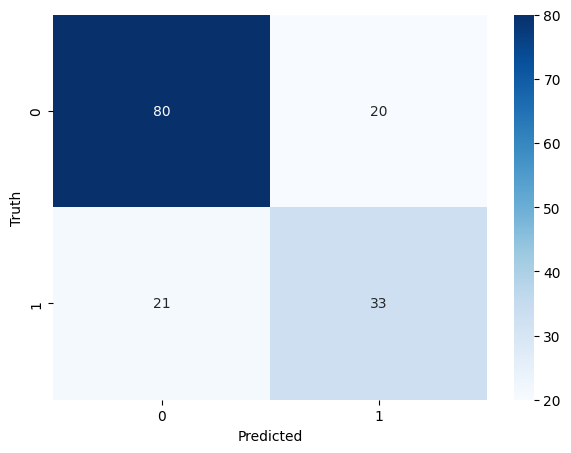

In [26]:
cm = confusion_matrix(y_test, model1.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Random Forest Model Evaluation

In [27]:
with open('random_forest_model.p', 'rb') as file:
    model2 = pickle.load(file)

In [28]:
model2.score(x_train,y_train)

1.0

In [29]:
model2.score(x_test,y_test)

0.7727272727272727

Text(58.222222222222214, 0.5, 'Truth')

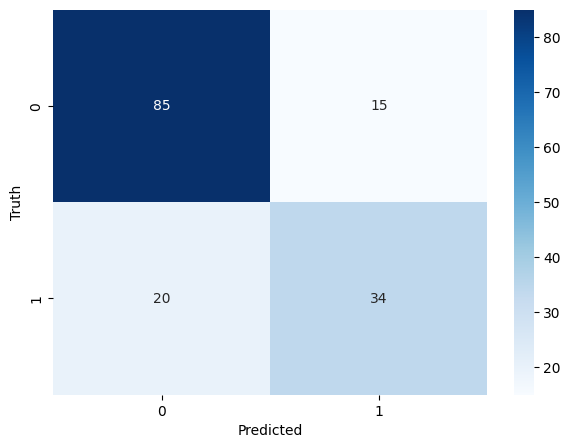

In [30]:
cm = confusion_matrix(y_test, model2.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Naive Bayes Model Evaluation

In [31]:
with open('naive_bayes_model.p', 'rb') as file:
    model3 = pickle.load(file)

In [32]:
model3.score(x_train,y_train)

0.760586319218241

In [33]:
model3.score(x_test,y_test)

0.7792207792207793

Text(58.222222222222214, 0.5, 'Truth')

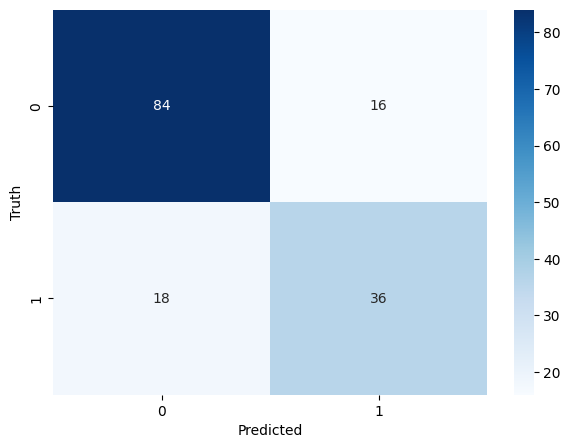

In [34]:
cm = confusion_matrix(y_test, model3.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Logistic Regression Model Evaluation

In [35]:
with open('logistic_regression_model.p', 'rb') as file:
    model4 = pickle.load(file)

In [36]:
model4.score(x_train,y_train)

0.7638436482084691

In [37]:
model4.score(x_test,y_test)

0.7922077922077922

Text(58.222222222222214, 0.5, 'Truth')

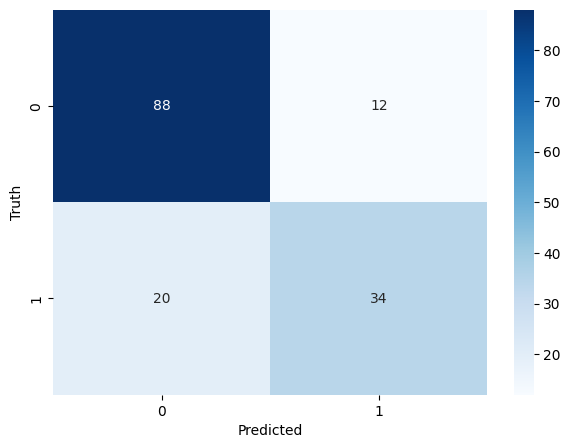

In [38]:
cm = confusion_matrix(y_test, model4.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')